# Case Study Overview

**Yourcabs.com** faces a critical business issue: *drivers frequently cancel scheduled rides, leaving customers stranded and dissatisfied.* 


Using historical booking data, your task is to build a predictive model to classify rides as **"cancelled"** or **"not cancelled."**

# Importing required packages

In [92]:
# For performing operation on dataframe
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# For Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Importing objects to build NN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

import shap

### Reading the data file

In [93]:
taxi_df = pd.read_csv("Taxi-cancellation-case.csv")

In [94]:
taxi_df.head(10)

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,1/1/13 22:33,NaN,0,0,1/1/13 8:01,13.028530,77.546250,12.869805,77.653211,0
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,1/1/13 12:43,NaN,0,0,1/1/13 9:59,12.999874,77.678120,12.953434,77.706510,0
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,1/2/13 0:28,1/3/13 0:00,1,0,1/1/13 12:14,12.908993,77.688900,13.199560,77.706880,0
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,1/1/13 13:12,NaN,0,0,1/1/13 12:42,12.997890,77.614880,12.994740,77.607970,0
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,1/1/13 16:33,NaN,0,0,1/1/13 15:07,12.926450,77.612060,12.858833,77.589127,0
5,6,38966,12,NaN,2,61.0,393.0,NaN,NaN,1/1/13 18:00,NaN,0,0,1/1/13 15:11,12.962980,77.712290,13.199560,77.706880,0
6,7,22196,12,NaN,2,409.0,1194.0,NaN,NaN,1/1/13 16:19,NaN,0,0,1/1/13 15:40,13.077460,77.606680,13.004460,77.569230,0
7,8,22200,12,NaN,2,1371.0,839.0,NaN,NaN,1/2/13 10:33,NaN,1,0,1/1/13 17:21,13.000418,77.674835,12.857730,77.786420,0
8,9,22201,12,1.0,3,1323.0,NaN,NaN,NaN,1/1/13 19:55,1/1/13 0:00,1,0,1/1/13 17:25,12.869805,77.653211,NaN,NaN,0
9,10,22202,12,NaN,2,1017.0,496.0,NaN,NaN,1/2/13 5:02,NaN,0,0,1/1/13 17:30,13.110840,77.600740,13.058450,77.640750,0


## EDA and Data Cleaning

**Fixing the datatype of columns**

In [95]:
# For all the datetime columns
for col in ['from_date', 'to_date', 'booking_created']:
    taxi_df[col] = pd.to_datetime(taxi_df[col], format = '%m/%d/%y %H:%M', errors='coerce')

# Converting from float to int
taxi_df['from_area_id'] = taxi_df['from_area_id'].astype('Int64')
taxi_df['to_area_id'] = taxi_df['to_area_id'].astype('Int64')
taxi_df['package_id'] = taxi_df['package_id'].astype('Int64')
taxi_df['from_city_id'] = taxi_df['from_city_id'].astype('Int64')
taxi_df['to_city_id'] = taxi_df['to_city_id'].astype('Int64')

**Extracting features from timestamps**

In [96]:
taxi_df['booking_year'] = taxi_df['booking_created'].dt.year
taxi_df['booking_month'] = taxi_df['booking_created'].dt.month  
taxi_df['booking_day'] = taxi_df['booking_created'].dt.day  
taxi_df['booking_hour'] = taxi_df['booking_created'].dt.hour  
taxi_df['from_date_month'] = taxi_df['from_date'].dt.month
taxi_df['from_date_day'] = taxi_df['from_date'].dt.day

In [97]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   row#                 10000 non-null  int64         
 1   user_id              10000 non-null  int64         
 2   vehicle_model_id     10000 non-null  int64         
 3   package_id           1752 non-null   Int64         
 4   travel_type_id       10000 non-null  int64         
 5   from_area_id         9985 non-null   Int64         
 6   to_area_id           7909 non-null   Int64         
 7   from_city_id         3706 non-null   Int64         
 8   to_city_id           339 non-null    Int64         
 9   from_date            10000 non-null  datetime64[ns]
 10  to_date              5822 non-null   datetime64[ns]
 11  online_booking       10000 non-null  int64         
 12  mobile_site_booking  10000 non-null  int64         
 13  booking_created      10000 non-n

**Visualization Overall Cancellation rate**

<Axes: xlabel='Car_Cancellation', ylabel='user_id'>

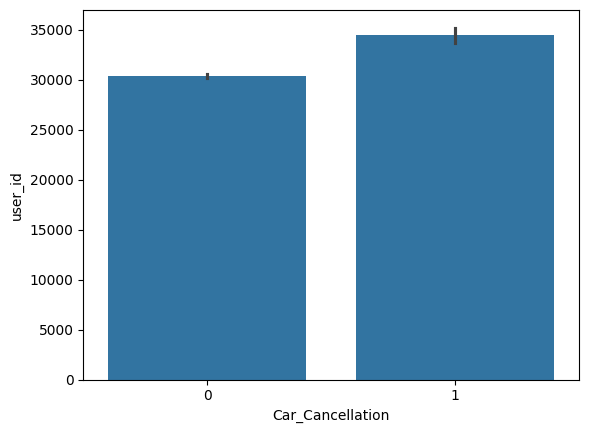

In [98]:
sns.barplot(taxi_df, x = "Car_Cancellation", y = "user_id")

### Looking into missing values

<Axes: >

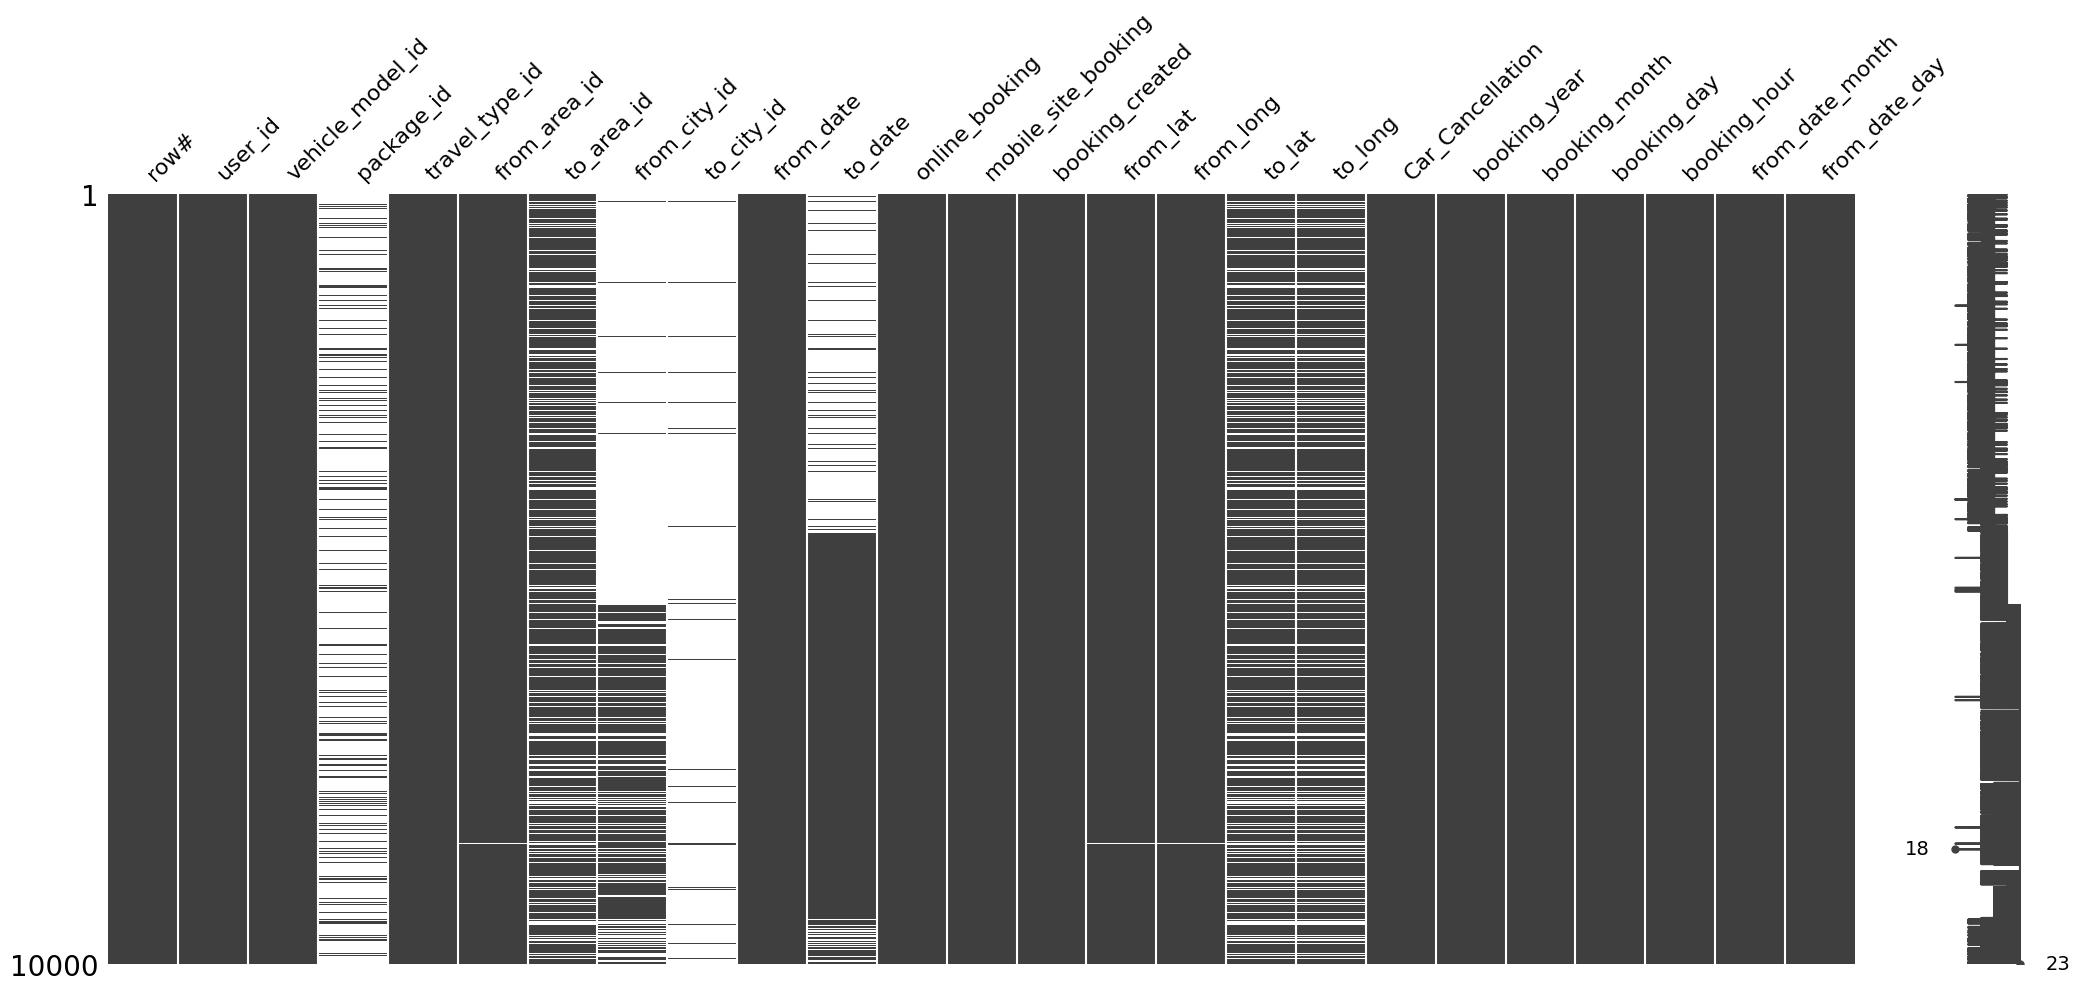

In [99]:
# This library help us visualize missing values :)
import missingno as msno
msno.matrix(taxi_df[taxi_df.columns])

In [100]:
# Percentage of missing values
missing_percentage = (taxi_df.isnull().sum() / len(taxi_df)) * 100

# Filter columns with missing values
missing_percentage = missing_percentage[missing_percentage > 0]
missing_percentage.sort_values(ascending=False)

to_city_id      96.61
package_id      82.48
from_city_id    62.94
to_date         41.78
to_area_id      20.91
to_lat          20.91
to_long         20.91
from_area_id     0.15
from_lat         0.15
from_long        0.15
dtype: float64

**Criteria for dropping the features: >70%**

**Imputing the missing values: <40-50%**

**Dropping columns that do not contribute**

In [101]:
# Dropping the following features 'package_id', 'from_city_id', 'to_city_id'
# since they contain high volumn of missing values.
taxi_df.drop(['row#', 'package_id', 'user_id', 'from_city_id', 'to_city_id', 'to_date', 'from_date', 'booking_created'], axis = 1, inplace = True)

## Imputing Missing values

In [102]:
imputer = SimpleImputer(strategy='most_frequent')
imputed_data = imputer.fit_transform(taxi_df.select_dtypes(include = ['int', 'float']))

In [103]:
imputed_data = pd.DataFrame(imputed_data, columns = taxi_df.select_dtypes(include = ['int', 'float']).columns, index = taxi_df.select_dtypes(include = ['int', 'float']).index) 

In [104]:
taxi_df[taxi_df.select_dtypes(include = ['int', 'float']).columns] = imputed_data

### **Visualizing the distribution of Features by Car_Cancellation**

C:\Users\shyam\AppData\Local\Temp\ipykernel_24648\1162711879.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = taxi_df, x = feature, hue = "Car_Cancellation", ax=axes[i], fill=True)
C:\Users\shyam\AppData\Local\Temp\ipykernel_24648\1162711879.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = taxi_df, x = feature, hue = "Car_Cancellation", ax=axes[i], fill=True)


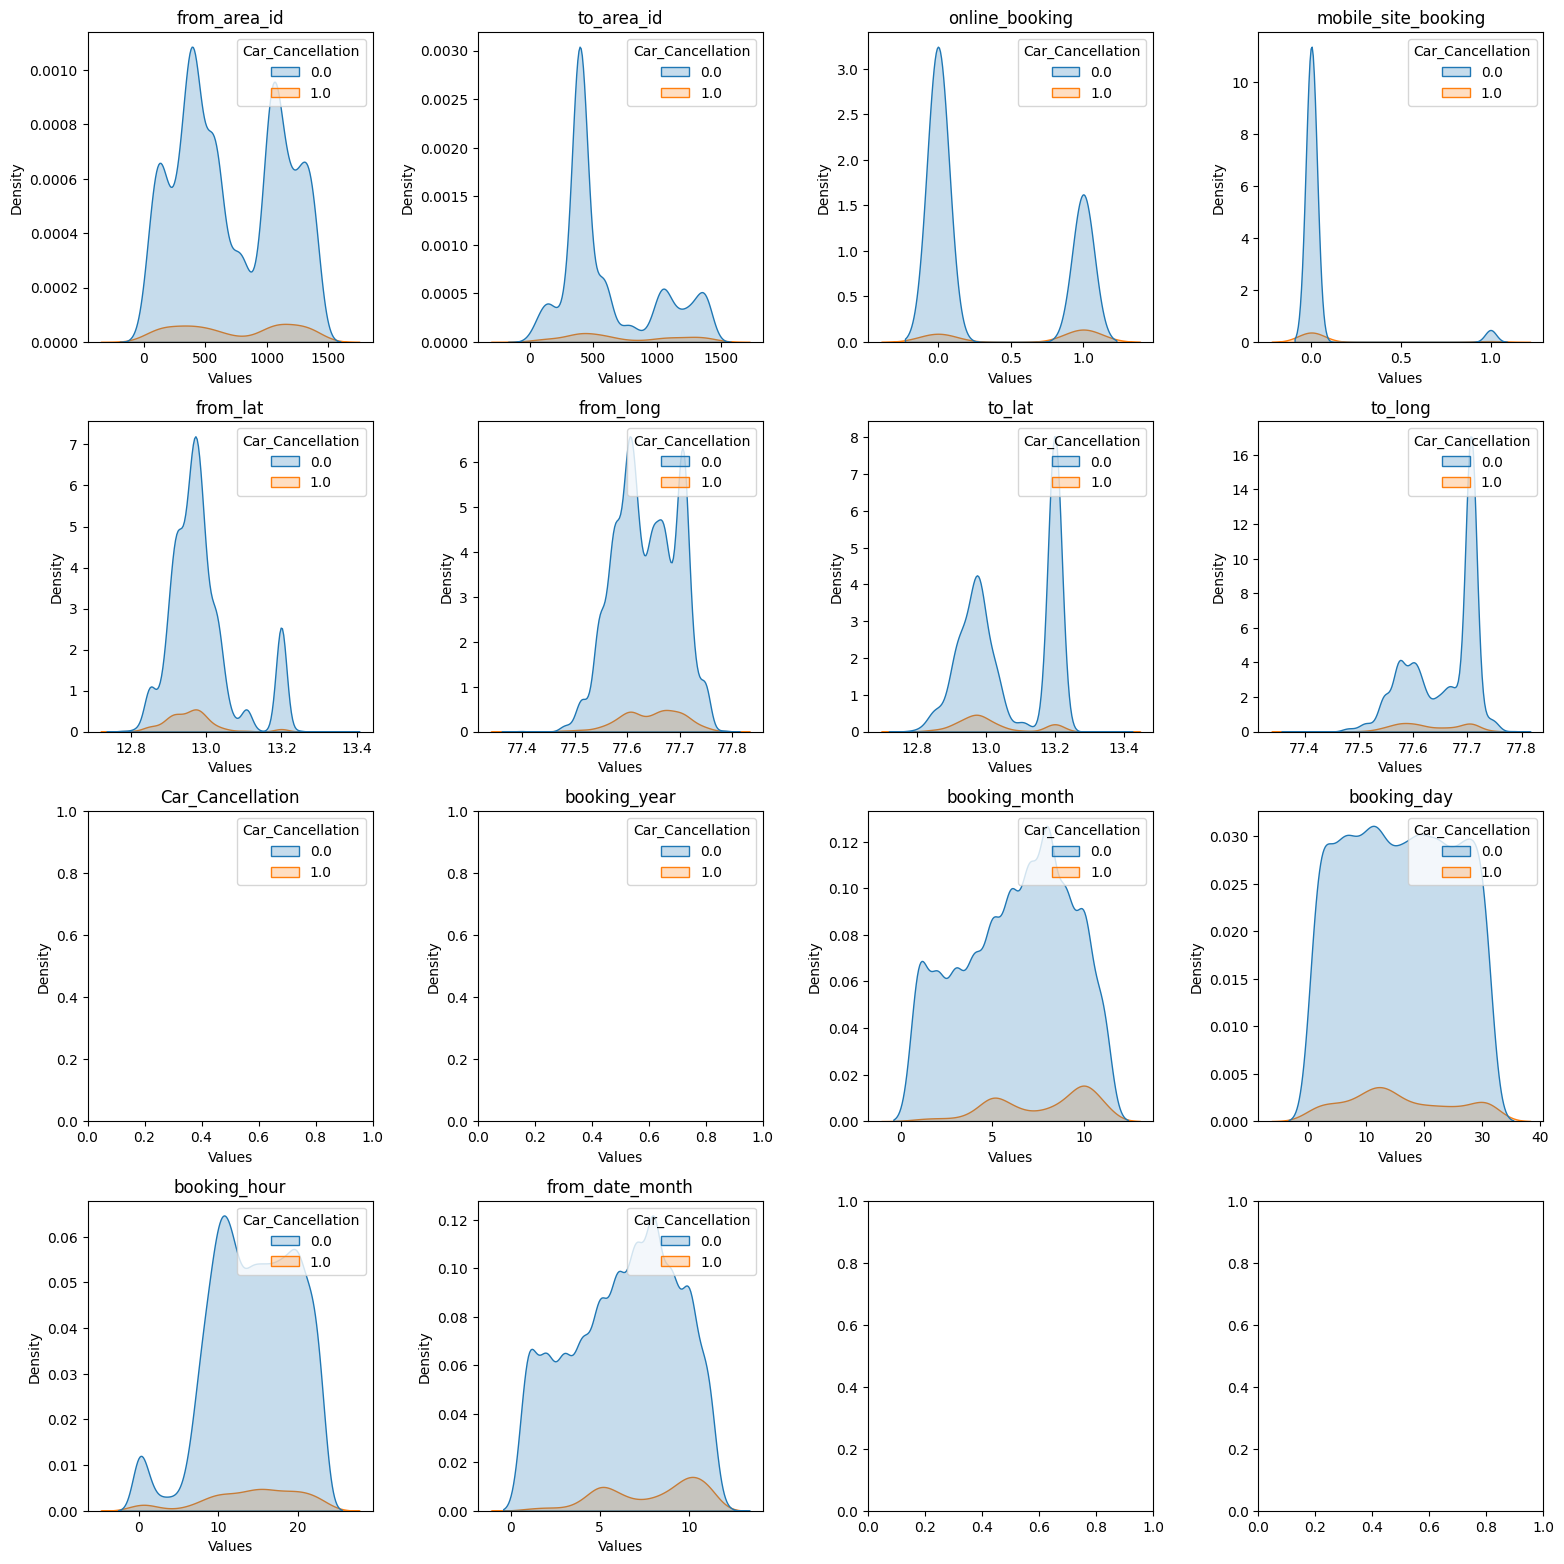

In [105]:
# Selecting the features to visualize their distribution
selected_features = taxi_df.columns[2:-1]

# Creating a 4x4 subplot 
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16,16))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.kdeplot(data = taxi_df, x = feature, hue = "Car_Cancellation", ax=axes[i], fill=True)
    axes[i].set_title(feature, fontsize=12)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Density')

plt.tight_layout(pad=2.0, h_pad=1.0)

## Train-Test split

In [106]:
X = taxi_df.drop('Car_Cancellation', axis=1)
y = taxi_df['Car_Cancellation']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardizing the data

In [108]:
num_cols = X_train.select_dtypes('float').columns

# Scaling the data so that model can be train on features with same scale of value.
scaler = StandardScaler()
X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])
X_test.loc[:, num_cols] = scaler.transform(X_test[num_cols])

## Developing the Neural Network

In [109]:
model = Sequential([
    Dense( 32, input_dim = X_train.shape[1], activation = 'relu'),
    Dense( 16, activation = 'relu'),
    Dense( 1, activation = 'sigmoid'),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

D:\python virtual environment\dl\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [110]:
epochs_logs = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)
epochs_logs

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8395 - loss: 0.4087 - val_accuracy: 0.9380 - val_loss: 0.2215
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9225 - loss: 0.2349 - val_accuracy: 0.9380 - val_loss: 0.2140
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9182 - loss: 0.2352 - val_accuracy: 0.9380 - val_loss: 0.2116
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9219 - loss: 0.2274 - val_accuracy: 0.9370 - val_loss: 0.2112
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9235 - loss: 0.2208 - val_accuracy: 0.9375 - val_loss: 0.2100
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9214 - loss: 0.2233 - val_accuracy: 0.9380 - val_loss: 0.2112
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9212 - loss: 0.2259 - val_accuracy: 0.9370 - val_loss: 0.2111
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9224 - loss: 0.2235 - val_accuracy: 0.

In [111]:
# Get predicted probabilities (shape: (n_samples,))
y_val_pred_prob = model.predict(X_test).ravel()

# Convert probabilities to 0/1 predictions
threshold = 0.5
y_val_pred = (y_val_pred_prob >= threshold).astype(int)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Performance Matrices

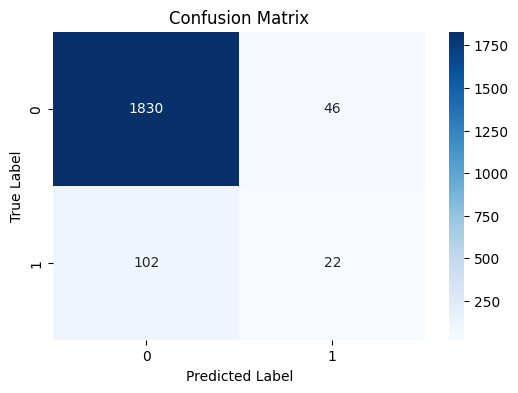

Accuracy:  0.9260
Precision: 0.3235
Recall:    0.1774
F1 Score:  0.2292


In [112]:
cm = confusion_matrix(y_test, y_val_pred)
acc = accuracy_score(y_test, y_val_pred)
precision = precision_score(y_test, y_val_pred)
recall = recall_score(y_test, y_val_pred)
f1 = f1_score(y_test, y_val_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # 'fmt="d"' -> integer display
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

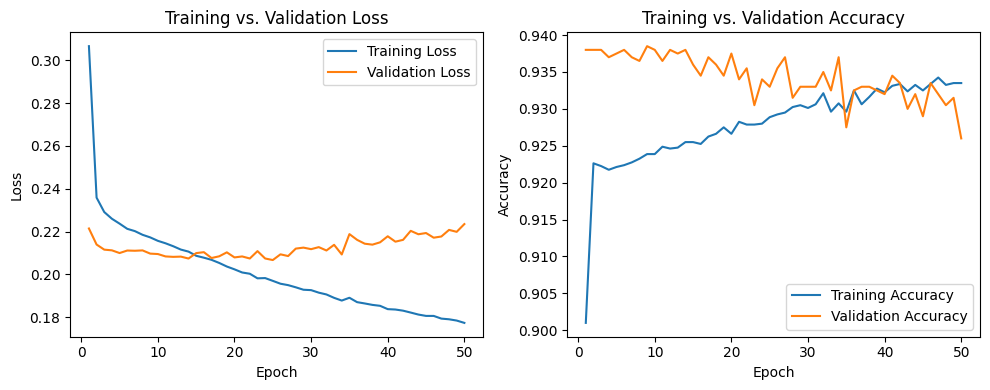

In [113]:
# Convert the history logs to a DataFrame
hist_df = pd.DataFrame(epochs_logs.history)
# hist_df columns typically: ['loss', 'accuracy', 'val_loss', 'val_accuracy']

# Create an "epoch" column
hist_df['epoch'] = range(1, len(hist_df) + 1)

# Plot Training vs. Validation Loss
plt.figure(figsize=(10,4))

# ---- LOSS ----
plt.subplot(1, 2, 1)
sns.lineplot(data=hist_df, x='epoch', y='loss', label='Training Loss')
sns.lineplot(data=hist_df, x='epoch', y='val_loss', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# ---- ACCURACY ----
plt.subplot(1, 2, 2)
sns.lineplot(data=hist_df, x='epoch', y='accuracy', label='Training Accuracy')
sns.lineplot(data=hist_df, x='epoch', y='val_accuracy', label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


## Analyzing Key Indicators

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

IndexError: index 1276 is out of bounds for axis 0 with size 100

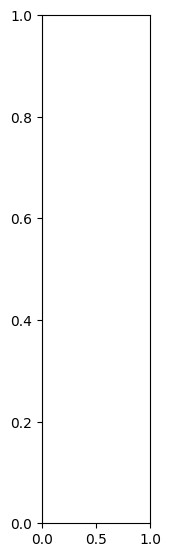

In [117]:
explainer = shap.KernelExplainer(model.predict,shap.sample(X_train,100))
shap_values = explainer.shap_values(X_test,nsamples=100)
shap.summary_plot(shap_values,shap.sample(X_test,100),feature_names=X_train.columns)

## Assess the Model's Lift Curve

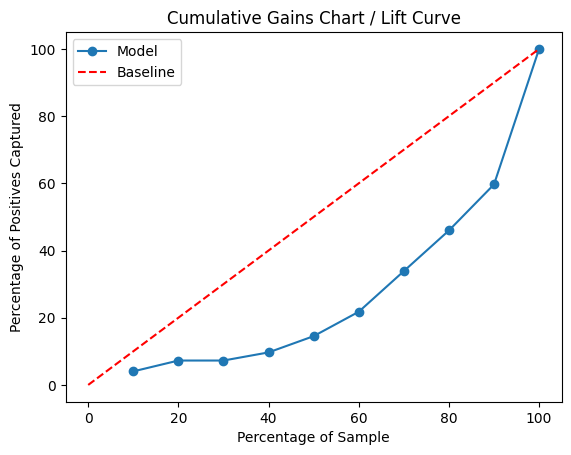

In [114]:
# 1) Sort validation data by predicted prob
results_df = pd.DataFrame({
    'y_true': y_test,
    'y_prob': y_val_pred_prob
})
results_df.sort_values('y_prob', ascending=False, inplace=True)

# 2) Create deciles
results_df['decile'] = pd.qcut(results_df['y_prob'], q=10, labels=False, duplicates='drop')

# 3) Aggregate by decile
lift_table = results_df.groupby('decile').agg({
    'y_true': ['count', 'sum']
})
lift_table.columns = ['count', 'sum_positives']
lift_table['cumulative_count'] = lift_table['count'].cumsum()
lift_table['cumulative_positives'] = lift_table['sum_positives'].cumsum()

# 4) Calculate cumulative gains
total_positives = lift_table['sum_positives'].sum()
lift_table['gain'] = lift_table['cumulative_positives'] / total_positives

# 5) Plot the Gains Chart or Lift Curve
x_values = 100 * (lift_table['cumulative_count'] / len(results_df))  # as %
y_values = 100 * lift_table['gain']

plt.plot(x_values, y_values, marker='o', label='Model')
plt.plot([0, 100], [0, 100], 'r--', label='Baseline')  # reference line
plt.title('Cumulative Gains Chart / Lift Curve')
plt.xlabel('Percentage of Sample')
plt.ylabel('Percentage of Positives Captured')
plt.legend()
plt.show()